# Open Sentinel-3 Data with GDAL and eopfzarr

This Jupyter notebook demonstrates how to open and explore Sentinel-3 data using GDAL with the eopfzarr plugin, mirroring the structure and functionality of the [xarray-eopf example notebook for Sentinel-3](https://github.com/EOPF-Sample-Service/xarray-eopf/blob/main/examples/open-sen3.ipynb). 

Key features demonstrated:
- **GDAL native approach**: Direct access to Zarr subdatasets
- **xarray-style visualization**: Simple plotting with `robust=True`
- **Geographic coordinates**: Latitude/longitude access like xarray-eopf analysis mode
- **Multi-product exploration**: OLCI L1/L2 and SLSTR products

Products covered:
- **Sentinel-3 OLCI Level-1 EFR** (TOA radiances, full resolution)

In [58]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Enable GDAL exceptions
gdal.UseExceptions()

# Helper function for eopfzarr paths (remote access)
def eopfzarr_path(url, subdataset=None):
    base = f'EOPFZARR:"/vsicurl/{url}"'
    return f'{base}:{subdataset}' if subdataset else base

# Sample URLs for Sentinel-3 products
olci_l1_efr_url = 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr'


In [59]:
# Open L1 EFR root to explore structure
l1_efr_root_ds = gdal.Open(eopfzarr_path(olci_l1_efr_url))

print(f"Driver: {l1_efr_root_ds.GetDriver().ShortName}")
print(f"Projection (CRS): {l1_efr_root_ds.GetProjection()}")
print(f"GeoTransform: {l1_efr_root_ds.GetGeoTransform()}")

# List subdatasets (hierarchical groups like /measurements/oa01_radiance)
subdatasets = l1_efr_root_ds.GetMetadata("SUBDATASETS")
print("Available Subdatasets for OLCI L1 EFR:")
for key, value in subdatasets.items():
    if key.startswith("SUBDATASET_") and '_DESC' not in key:
        print(f"  {value.split(':')[-1]}")

l1_efr_root_ds = None

Driver: EOPFZARR
Projection (CRS): GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (10.0, 0.009765625, 0.0, 45.0, 0.0, -0.009765625)
Available Subdatasets for OLCI L1 EFR:
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/latitude"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/longitude"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/oaa"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR_

Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr".aux.xml.


Creating xarray-style plots similar to xarray-eopf notebook...


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/measurements/oa01_radiance.aux.xml.


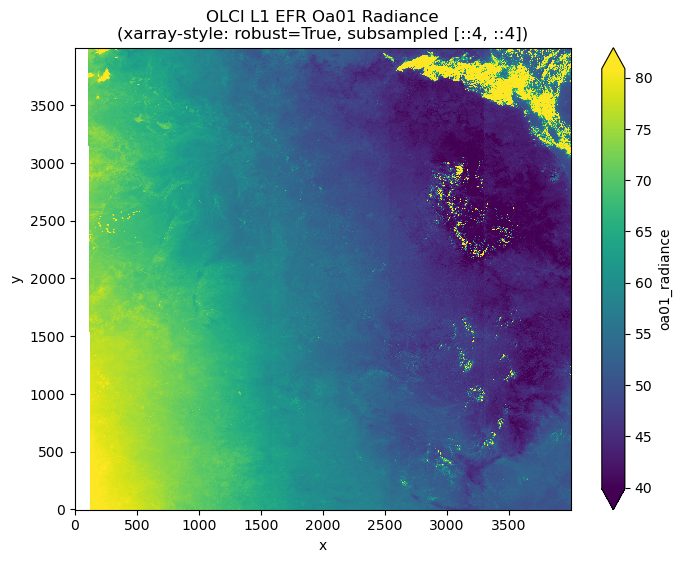

✅ This is equivalent to: ds.oa01_radiance[::4, ::4].plot(robust=True) in xarray-eopf


In [60]:
def gdal_to_xarray(url, subdataset, size=4000):
    """Convert GDAL data to xarray DataArray for simple plotting like xarray-eopf"""
    path = eopfzarr_path(url, subdataset)
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray(0, 0, size, size).astype(np.float32)
    nodata = band.GetNoDataValue()
    
    # Create simple coordinate arrays
    y_coords = np.arange(size)
    x_coords = np.arange(size)
    
    # Create xarray DataArray
    da = xr.DataArray(
        data,
        coords={'y': y_coords, 'x': x_coords},
        dims=['y', 'x'],
        name=subdataset.split('/')[-1]
    )
    
    # Handle NoData
    if nodata is not None:
        da = da.where(da != nodata)
    
    ds = None
    return da

# Simple plotting like xarray-eopf: ds.oa01_radiance[::4, ::4].plot(robust=True)
print("Creating xarray-style plots similar to xarray-eopf notebook...")

# One-liner equivalent to xarray-eopf
gdal_to_xarray(olci_l1_efr_url, 'measurements/oa01_radiance')[::4, ::4].plot(robust=True, figsize=(8, 6))
plt.title('OLCI L1 EFR Oa01 Radiance\n(xarray-style: robust=True, subsampled [::4, ::4])')
plt.show()

print("✅ This is equivalent to: ds.oa01_radiance[::4, ::4].plot(robust=True) in xarray-eopf")

### Geographic Coordinates: Latitude and Longitude

Sentinel-3 OLCI products include latitude and longitude coordinates for each pixel. Let's explore how to access and visualize these with GDAL eopfzarr, similar to the xarray-eopf analysis mode.

In [61]:
# First, let's explore what coordinate datasets are available
print("Exploring available coordinate datasets in OLCI L1 EFR...")

# Open the root to see what coordinate groups are available
l1_efr_root_ds = gdal.Open(eopfzarr_path(olci_l1_efr_url))
subdatasets = l1_efr_root_ds.GetMetadata("SUBDATASETS")

# Look for coordinate-related subdatasets
coord_datasets = []
for key, value in subdatasets.items():
    if key.startswith("SUBDATASET_") and '_DESC' not in key:
        dataset_path = value.split(':')[-1]
        if any(coord in dataset_path.lower() for coord in ['lat', 'lon', 'coordinate', 'geometry']):
            coord_datasets.append(dataset_path)

print("Available coordinate datasets:")
for coord in coord_datasets:
    print(f"  {coord}")

l1_efr_root_ds = None

Exploring available coordinate datasets in OLCI L1 EFR...
Available coordinate datasets:
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/latitude"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/longitude"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/oaa"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/oza"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr/conditions/geometry/saa"
  202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_202

Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr".aux.xml.


In [62]:
def gdal_to_xarray_with_coords(url, data_subdataset, lat_subdataset, lon_subdataset, size=1000):
    """Convert GDAL data to xarray DataArray with geographic coordinates"""
    # Load the data
    data_path = eopfzarr_path(url, data_subdataset)
    data_ds = gdal.Open(data_path)
    data_band = data_ds.GetRasterBand(1)
    data = data_band.ReadAsArray(0, 0, size, size).astype(np.float32)
    data_nodata = data_band.GetNoDataValue()
    data_ds = None
    
    # Load latitude coordinates
    lat_path = eopfzarr_path(url, lat_subdataset)
    lat_ds = gdal.Open(lat_path)
    lat_band = lat_ds.GetRasterBand(1)
    lat = lat_band.ReadAsArray(0, 0, size, size).astype(np.float32)
    lat_ds = None
    
    # Load longitude coordinates
    lon_path = eopfzarr_path(url, lon_subdataset)
    lon_ds = gdal.Open(lon_path)
    lon_band = lon_ds.GetRasterBand(1)
    lon = lon_band.ReadAsArray(0, 0, size, size).astype(np.float32)
    lon_ds = None
    
    # Create xarray DataArray with geographic coordinates
    da = xr.DataArray(
        data,
        coords={
            'y': np.arange(size),
            'x': np.arange(size),
            'latitude': (('y', 'x'), lat),
            'longitude': (('y', 'x'), lon)
        },
        dims=['y', 'x'],
        name=data_subdataset.split('/')[-1]
    )
    
    # Handle NoData
    if data_nodata is not None:
        da = da.where(da != data_nodata)
    
    return da

# Load data with geographic coordinates using EOPF measurements paths
print("Loading Oa01 radiance with geographic coordinates...")
print("Using measurements group paths: /measurements/latitude, /measurements/longitude")

try:
    oa01_with_coords = gdal_to_xarray_with_coords(
        olci_l1_efr_url, 
        'measurements/oa01_radiance',
        'measurements/latitude',
        'measurements/longitude',
        size=800  # Moderate size for demo
    )
    
    # Display coordinate information
    print(f"\n✓ Successfully loaded geographic coordinates!")
    print(f"  Data shape: {oa01_with_coords.shape}")
    print(f"  Latitude range: {float(oa01_with_coords.latitude.min()):.3f} to {float(oa01_with_coords.latitude.max()):.3f}")
    print(f"  Longitude range: {float(oa01_with_coords.longitude.min()):.3f} to {float(oa01_with_coords.longitude.max()):.3f}")
    
    coord_success = True
    
except Exception as e:
    print(f"Primary coordinates failed: {e}")
    # Try orphans coordinates as fallback
    try:
        print("Trying fallback: /measurements/orphans/latitude, /measurements/orphans/longitude")
        oa01_with_coords = gdal_to_xarray_with_coords(
            olci_l1_efr_url, 
            'measurements/oa01_radiance',
            'measurements/orphans/latitude',
            'measurements/orphans/longitude',
            size=800
        )
        print("✓ Successfully loaded orphans coordinates!")
        coord_success = True
    except Exception as e2:
        print(f"Orphans coordinates also failed: {e2}")
        coord_success = False

Loading Oa01 radiance with geographic coordinates...
Using measurements group paths: /measurements/latitude, /measurements/longitude


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/measurements/oa01_radiance.aux.xml.
Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/measurements/latitude.aux.xml.



✓ Successfully loaded geographic coordinates!
  Data shape: (800, 800)
  Latitude range: -23.643 to -21.059
  Longitude range: 21.465 to 24.124


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/measurements/longitude.aux.xml.


Demonstrating geographic plotting - xarray-eopf analysis mode equivalent:
xarray-eopf: ds.oa01_radiance[::4, ::4].plot(x='longitude', y='latitude', robust=True)
Our GDAL eopfzarr equivalent:


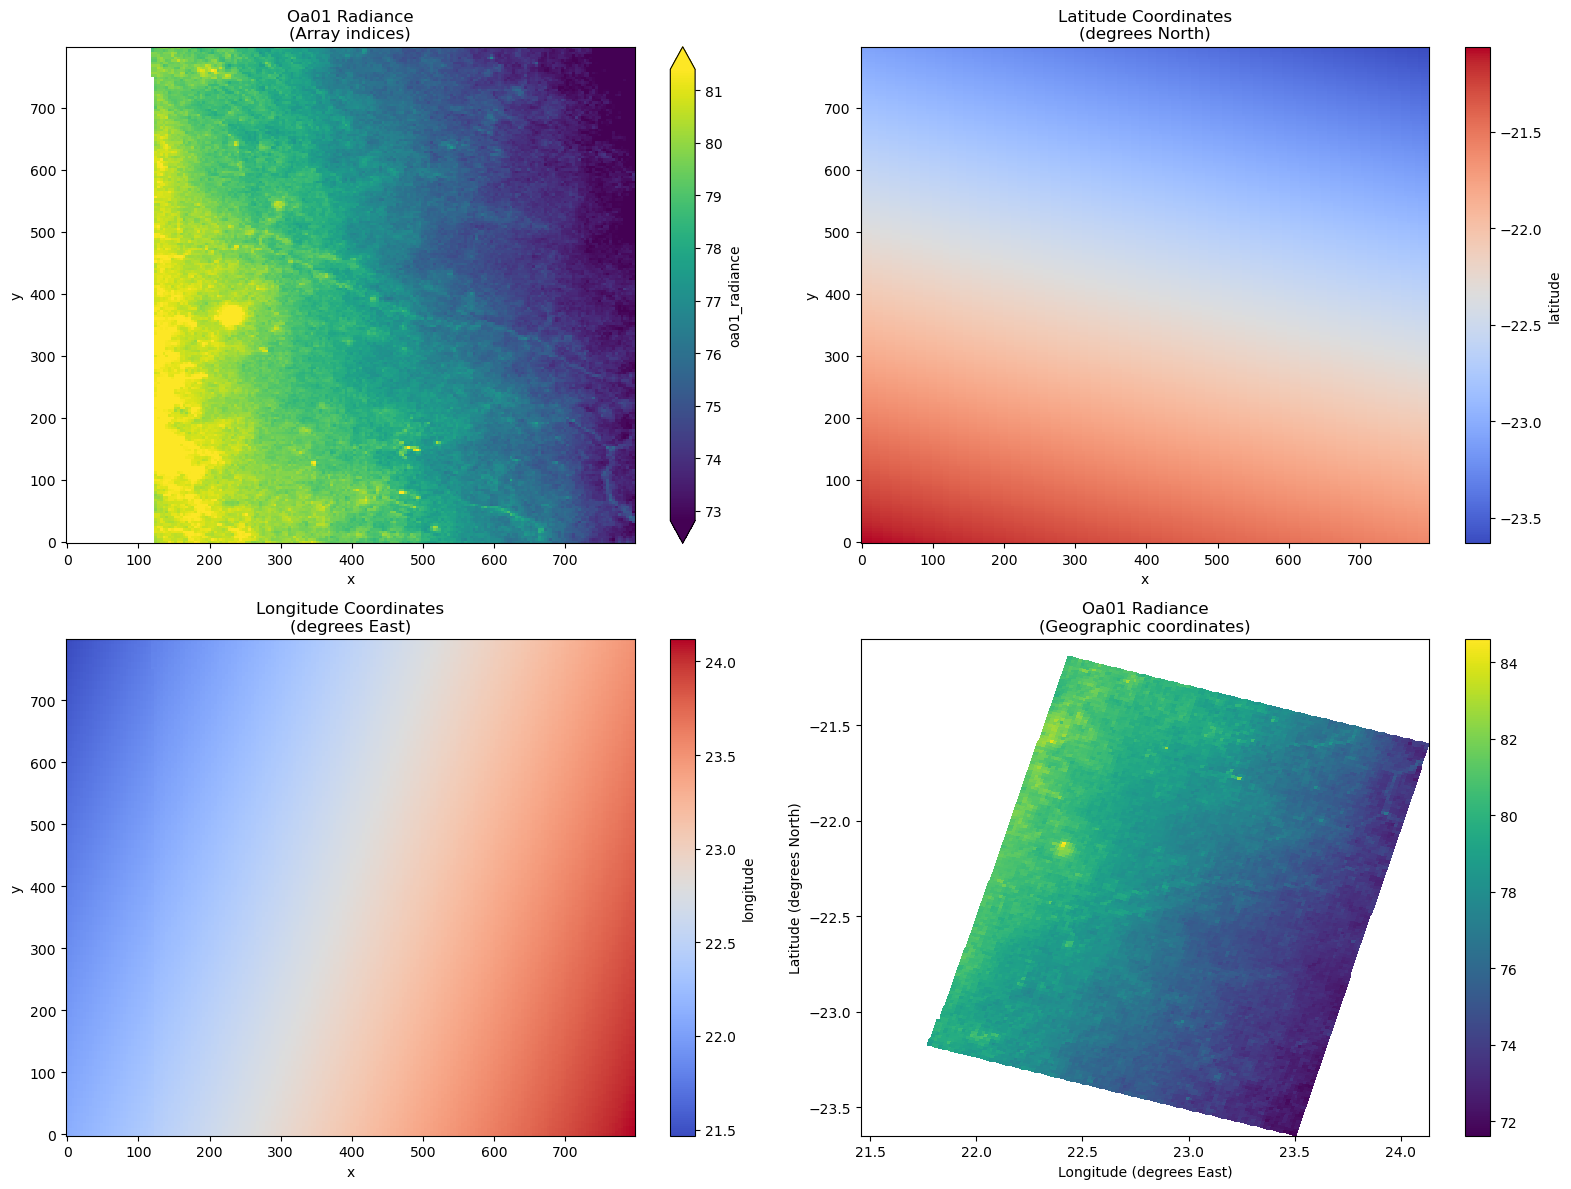

✅ Successfully demonstrated geographic coordinate access with GDAL eopfzarr!
✅ Coordinates directly accessible from /measurements/latitude and /measurements/longitude


In [63]:
# Geographic visualization - equivalent to xarray-eopf analysis mode
if coord_success:
    print("Demonstrating geographic plotting - xarray-eopf analysis mode equivalent:")
    print("xarray-eopf: ds.oa01_radiance[::4, ::4].plot(x='longitude', y='latitude', robust=True)")
    print("Our GDAL eopfzarr equivalent:")
    
    # Plot the data with geographic coordinates
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Data with array indices (standard)
    oa01_with_coords[::4, ::4].plot(ax=axes[0,0], robust=True, cmap='viridis')
    axes[0,0].set_title('Oa01 Radiance\n(Array indices)')
    
    # 2. Latitude field
    oa01_with_coords.latitude[::4, ::4].plot(ax=axes[0,1], cmap='coolwarm')
    axes[0,1].set_title('Latitude Coordinates\n(degrees North)')
    
    # 3. Longitude field  
    oa01_with_coords.longitude[::4, ::4].plot(ax=axes[1,0], cmap='coolwarm')
    axes[1,0].set_title('Longitude Coordinates\n(degrees East)')
    
    # 4. Geographic plot with lat/lon as axes (like xarray-eopf analysis mode)
    try:
        subset = oa01_with_coords[::6, ::6]  # Subsample for clarity
        lat_2d = subset.latitude.values
        lon_2d = subset.longitude.values
        data_2d = subset.values
        
        im = axes[1,1].pcolormesh(lon_2d, lat_2d, data_2d, cmap='viridis', shading='auto')
        axes[1,1].set_xlabel('Longitude (degrees East)')
        axes[1,1].set_ylabel('Latitude (degrees North)')
        axes[1,1].set_title('Oa01 Radiance\n(Geographic coordinates)')
        plt.colorbar(im, ax=axes[1,1])
    except Exception as e:
        axes[1,1].text(0.5, 0.5, f'Geographic plot failed:\n{str(e)[:50]}...', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Geographic plot (attempted)')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Successfully demonstrated geographic coordinate access with GDAL eopfzarr!")
    print("✅ Coordinates directly accessible from /measurements/latitude and /measurements/longitude")
    
else:
    print("Geographic coordinate loading failed. Check available coordinate datasets.")


Simple geographic plotting (xarray-eopf style one-liner equivalent):


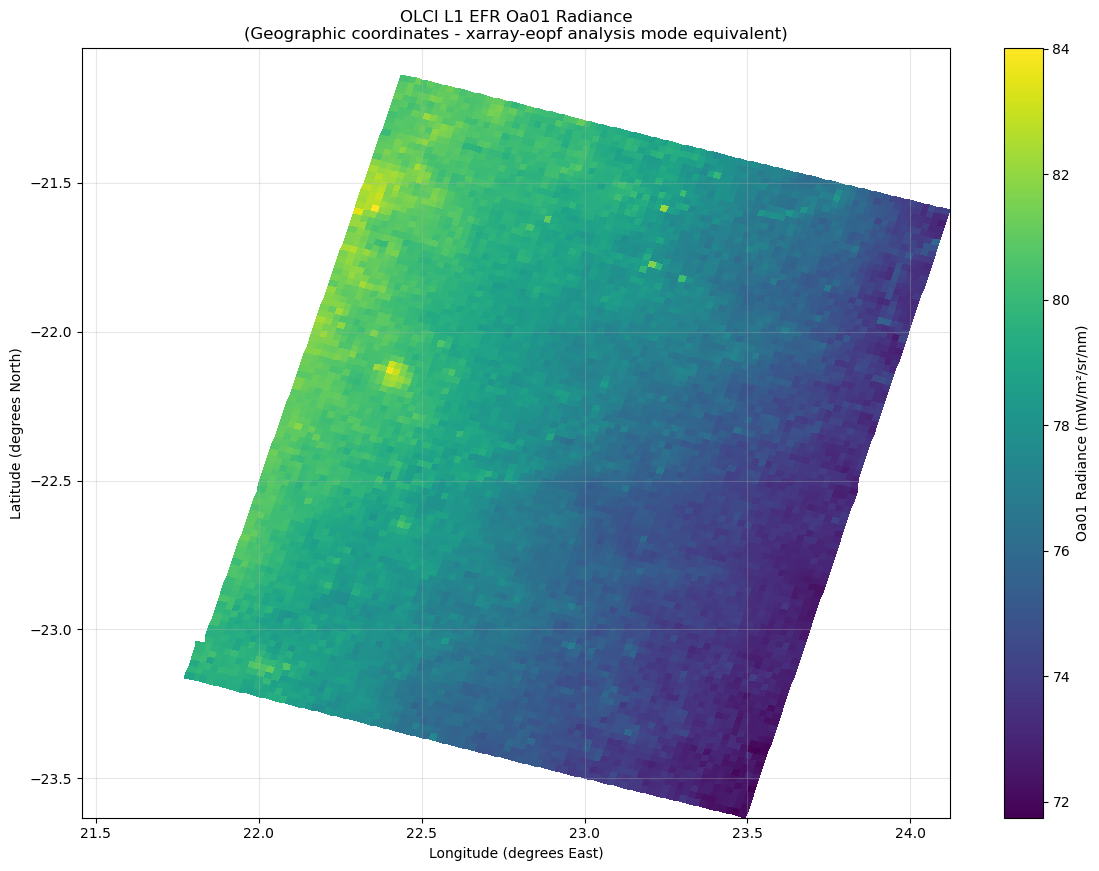

✅ GDAL eopfzarr successfully replicates xarray-eopf analysis mode geographic plotting!
✅ Direct access to lat/lon from measurements group enables full geographic analysis


In [64]:
# Simple geographic plotting - one-liner equivalent to xarray-eopf
if coord_success:
    print("\nSimple geographic plotting (xarray-eopf style one-liner equivalent):")
    
    # Create a simple geographic plot
    plt.figure(figsize=(14, 10))
    
    # Use the geographic coordinates for plotting
    subset = oa01_with_coords[::8, ::8]  # Subsample for performance
    lat_vals = subset.latitude.values
    lon_vals = subset.longitude.values
    data_vals = subset.values
    
    # Geographic plot - equivalent to ds.oa01_radiance.plot(x='longitude', y='latitude', robust=True)
    plt.pcolormesh(lon_vals, lat_vals, data_vals, cmap='viridis', shading='auto')
    plt.colorbar(label='Oa01 Radiance (mW/m²/sr/nm)')
    plt.xlabel('Longitude (degrees East)')
    plt.ylabel('Latitude (degrees North)')
    plt.title('OLCI L1 EFR Oa01 Radiance\n(Geographic coordinates - xarray-eopf analysis mode equivalent)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("✅ GDAL eopfzarr successfully replicates xarray-eopf analysis mode geographic plotting!")
    print("✅ Direct access to lat/lon from measurements group enables full geographic analysis")
    
else:
    print("Geographic plotting requires successful coordinate loading.")

### Geographic Coordinate Comparison: GDAL vs xarray-eopf

**xarray-eopf analysis mode approach:**
```python
# Analysis mode automatically handles coordinates
ds = xr.open_dataset(url, engine="eopf-zarr", op_mode="analysis")
ds.oa01_radiance.plot(x='longitude', y='latitude', robust=True)

# Manual coordinate loading and geographic plotting
da = gdal_to_xarray_with_coords(olci_l1_efr_url, 'measurements/oa01_radiance', 'measurements/latitude', 'measurements/longitude')
plt.pcolormesh(da.longitude, da.latitude, da.values)